In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torch.optim as optim
import matplotlib.pyplot as plt
from datetime import datetime
from torch.utils.data import dataset
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
import torchvision.transforms as transforms
import cv2

In [2]:
logWriter = SummaryWriter("runs")

In [26]:
class Rescale(object) :
    def __call__(self, data) : 
        data.div_(torch.max(data))
        return data

In [150]:
class EdgeMaker(object) :
    def __call__(self, data) : 
        frame = data.numpy()[ : , : : -1, :]
        frame = frame.transpose(1, 2, 0)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        sobelY = cv2.Sobel(frame, cv2.CV_64F, 0, 1, ksize = 3)
        sobelX = cv2.Sobel(frame, cv2.CV_64F, 1, 0, ksize = 3)
        output = sobelX + sobelY
        output = torch.from_numpy(output).float()
        return output.reshape(1, 32, 32)

In [151]:
transformTrain = transforms.Compose(
    [
     transforms.RandomRotation(degrees = 45), 
     transforms.RandomHorizontalFlip(),
     transforms.RandomVerticalFlip(),
     transforms.ToTensor(), 
     Rescale(),
     EdgeMaker(),
    ])
transformTest = transforms.Compose(
    [transforms.ToTensor(),
    Rescale(), 
    EdgeMaker()])

In [152]:
trainSet = datasets.CIFAR10(root = './data', train = True, download = True, transform = transformTrain)
testSet = datasets.CIFAR10(root = './data', train = False, download = True, transform = transformTest)

Files already downloaded and verified
Files already downloaded and verified


In [153]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [154]:
batchSize = 16
trainLoader = DataLoader(dataset = trainSet, batch_size = batchSize, shuffle = True)
testLoader = DataLoader(dataset = testSet, batch_size = batchSize, shuffle = True)

In [155]:
itr = iter(trainLoader)

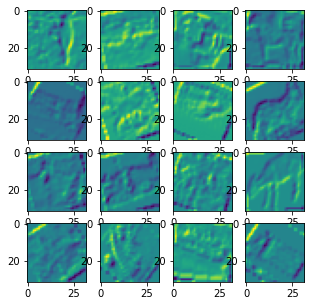

In [157]:
fig, ax = plt.subplots(4, 4, figsize=(5,5))

for i in range(4) :
    for j in range(4) :
        ax[i, j].imshow(itr.next()[0][i * 4 + j][0])


In [246]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.batchNormInput = nn.BatchNorm2d(1, affine=False)
        self.conv1 = nn.Conv2d(1, 20, 3, stride=2)
        self.batchNorm1 = nn.BatchNorm2d(20, affine=False)
        self.conv2 = nn.Conv2d(20, 64, 3, stride=2, padding = 3)
#         self.conv3 = nn.Conv2d(64, 64, 3, stride=2, padding = 1)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(576, 50)  # 5*5 from image dimension
        self.fc2 = nn.Linear(50, 16)
        self.fc3 = nn.Linear(16, 10)
        self.softmax = nn.Softmax(dim = 1)
        
    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = self.batchNormInput(x)
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = self.batchNorm1(x)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
#         x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def predict(self, x):
        # Max pooling over a (2, 2) window
        x = self.batchNormInput(x)
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = self.batchNorm1(x)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
#         x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.softmax(x)
        return x
    
    def test(self, x):
        # Max pooling over a (2, 2) window
        x = self.batchNormInput(x)
        print('Shape of input : ', x.shape)
        x = self.conv1(x)
        print('Shape after first convolution : ', x.shape)
        x = F.relu(x)
        print('Shape after relu : ', x.shape)
        x = F.max_pool2d(x, (2, 2))
        x = self.batchNorm1(x)
        print('Shape after first pooling : ', x.shape)
        # If the size is a square, you can specify with a single number
        x = self.conv2(x)
        print('Shape after second convolution : ', x.shape)
        x = F.relu(x)
        print('Shape after second relu : ', x.shape)
        x = F.max_pool2d(x, 2)
        print('Shape after second pooling : ', x.shape)
#         x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        print('Shape after third pooling : ', x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        print('Shape after flattening : ', x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        ans = torch.empty(x.shape[0])
        for index in range(len(ans)) : 
            ans[index] = torch.argmax(x[index])
        return ans

In [283]:
model = Net()

# PATH = 'savedModels/2021_12_30-23:45:24.pth'
# modelParams = torch.load(PATH)['params']
# trainingLosses = torch.load(PATH)['losses']
# model.load_state_dict(modelParams)

In [284]:
# logWriter.add_graph(model, itr.next()[0])

In [285]:
index = 1

itr = iter(trainLoader)
randomDataPoint = itr.next()

model.test(randomDataPoint[0].reshape(batchSize, 1, 32, 32))

Shape of input :  torch.Size([16, 1, 32, 32])
Shape after first convolution :  torch.Size([16, 20, 15, 15])
Shape after relu :  torch.Size([16, 20, 15, 15])
Shape after first pooling :  torch.Size([16, 20, 7, 7])
Shape after second convolution :  torch.Size([16, 64, 6, 6])
Shape after second relu :  torch.Size([16, 64, 6, 6])
Shape after second pooling :  torch.Size([16, 64, 3, 3])
Shape after third pooling :  torch.Size([16, 64, 3, 3])
Shape after flattening :  torch.Size([16, 576])


tensor([3., 6., 3., 3., 3., 8., 3., 3., 3., 3., 6., 3., 8., 3., 3., 3.])

In [286]:
def makeTrainStep(model, optimizer, lossFn) :
    
    def trainStep (xTrain, yTrain) :
        model.train()
        yPred = model(xTrain)
        loss = lossFn(yPred, yTrain)
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        return loss.detach()
        
    return trainStep        

In [287]:
losses = []
epoch = 0

In [288]:
nEpochs = 20
learningRate= 0.01
lossFn = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=learningRate)

trainingStep = makeTrainStep(model, optimizer, lossFn)

while epoch < nEpochs : 
    print('Pass : ', epoch + 1, ' of ', nEpochs)
    runningLoss = torch.zeros(1)
    for i, data in enumerate(trainLoader, 0):
        xBatch, yBatch = data
        loss = trainingStep(xBatch, yBatch)
        runningLoss += loss.item()
    logWriter.add_scalar('Loss (log)', torch.log(runningLoss), epoch)
    losses.append(torch.log(runningLoss))
    
    if (epoch + 1)%10 == 0 :
        totalPredictions = 0
        correctPredictions = 0
        wrongPred1 = []
        model.eval()
#         for xTestBatch, yTestBatch in testLoader :
#             yPred = model.predict(xTestBatch)
#             correctPredictions += torch.eq(yPred, yTestBatch).sum()
#             totalPredictions += batchSize
#         logWriter.add_scalar('Accuracy', correctPredictions/totalPredictions, epoch)
    epoch += 1
print('Training loop complete')

Pass :  1  of  20
Pass :  2  of  20
Pass :  3  of  20
Pass :  4  of  20
Pass :  5  of  20
Pass :  6  of  20
Pass :  7  of  20
Pass :  8  of  20
Pass :  9  of  20
Pass :  10  of  20
Pass :  11  of  20
Pass :  12  of  20
Pass :  13  of  20
Pass :  14  of  20
Pass :  15  of  20
Pass :  16  of  20
Pass :  17  of  20
Pass :  18  of  20
Pass :  19  of  20
Pass :  20  of  20
Training loop complete


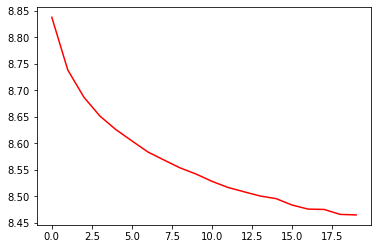

In [289]:
plt.plot(losses, color = 'red')

In [290]:
totalPredictions = 0
correctPredictions = 0
wrongPred1 = []
model.eval()
with torch.no_grad() :
    for xTestBatch, yTestBatch in testLoader :
        yPred = model.predict(xTestBatch)
    
        ans = torch.empty(yPred.shape[0])
        for index in range(len(ans)) : 
            ans[index] = torch.argmax(yPred[index])

        correctPredictions += torch.eq(ans, yTestBatch).sum()

        for i, sample in enumerate(ans, 0) : 
            if(ans[i] != yTestBatch[i]) :
                wrongPred1.append({'image' : xTestBatch[i].permute(1, 2, 0), 'answer' : yTestBatch[i], 'pred' : yPred[i].numpy()})
        totalPredictions += batchSize
    print('Accuracy : ', correctPredictions/totalPredictions)

Accuracy :  tensor(0.4790)


Answer :  ship


<BarContainer object of 10 artists>

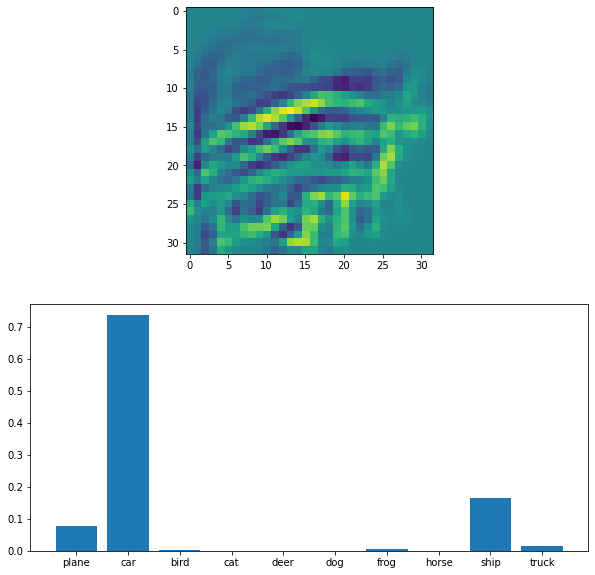

In [291]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))


i = 9
ax[0].imshow(wrongPred1[i]['image'])
print('Answer : ', classes[wrongPred1[i]['answer'].int()])
ax[1].bar(classes, wrongPred1[i]['pred'])

In [75]:
PATH = 'savedModels/' + datetime.now().strftime("%Y_%m_%d-%H:%M:%S") + '.pth'
torch.save({'params' : model.state_dict(), 'losses' : losses}, PATH)